# Training Tetris emulator - GameGAN

In this notebook, we train a Tetris emulator model inspired by GameGAN: https://nv-tlabs.github.io/gameGAN/.

# Setup

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


from models import TetrisModel, TetrisDiscriminator
import metrics
from recording import FileBasedDatabaseWithEvents

In [2]:
NUM_CELL_TYPES = 8
NUM_EVENT_TYPES = 5

class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self._db = FileBasedDatabaseWithEvents(path)

    def __len__(self):
        return len(self._db)

    def __getitem__(self, idx):
        boards, events = self._db[idx]
        b = self._transform_board(boards[-2]) # Ignore all boards except the last two
        e = self._transform_event(events[-1])
        x = (b, e)
        y = self._transform_board(boards[-1])
        return x, y
    
    def _transform_board(self, board):
        board = torch.tensor(board, dtype=torch.long)
        board = F.one_hot(board, NUM_CELL_TYPES) # One-hot encode the cell types
        board = board.type(torch.float) # Convert to floating-point
        board = board.permute((2, 0, 1)) # Move channels/classes to dimension 0
        return board
    
    def _transform_event(self, event):
        event = torch.tensor(event, dtype=torch.long)
        event = F.one_hot(event, NUM_EVENT_TYPES) # One-hot encode the event
        event = event.type(torch.float) # Convert to floating-point
        return event

In [3]:
train_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "train"))
test_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "test"))
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

(b, e), y = next(iter(train_dataloader))
print(f"x: shape {b.shape}, dtype {b.dtype}")
print(f"e: shape {e.shape}, dtype {e.dtype}")
print(f"y: shape {y.shape}, dtype {y.dtype}")

x: shape torch.Size([4, 8, 22, 10]), dtype torch.float32
e: shape torch.Size([4, 5]), dtype torch.float32
y: shape torch.Size([4, 8, 22, 10]), dtype torch.float32


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
def compute_metric_by_event(metric_cls, dataloader):
    metrics = [metric_cls() for _ in range(NUM_EVENT_TYPES)]

    with torch.no_grad():        
        for ((b, e), y) in dataloader:
            batch_size = b.size(0)

            y_fake = gen(b, e)
            
            classes_b = torch.argmax(b, dim=1)
            classes_e = torch.argmax(e, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)

            for idx in range(batch_size):
                class_e = classes_e[idx]
                metric = metrics[class_e]
                metric.update_state(classes_x=classes_b[idx:idx+1], classes_y_pred=classes_y_fake[idx:idx+1], classes_y=classes_y[idx:idx+1])

    return [metric.result() for metric in metrics]

In [78]:
import itertools

from engines import EventTypes

def find_interesting_examples(dataset, num=3):
    num_spawns = num
    
    def inner():
        num_spawns_left = num_spawns

        for (b, e), y in dataset:
            # Check for block spawn
            if (e.argmax(0).item() == EventTypes.DROP) & (b.argmax(0)[0] == 0).all() & (y.argmax(0)[0] > 0).any():
                if num_spawns_left > 0:
                    num_spawns_left -= 1
                    yield (b, e), y
                else:
                    continue
            
    return list(itertools.islice(inner(), num))
from tetris import CELL_COLORS

def render_board(board):
    height, width = board.shape
    img = np.zeros((3, height, width))
    for row in range(height):
        for col in range(width):
            img[:, row, col] = CELL_COLORS[board[row, col]]
    img /= 255.0
    return img
def render_prediction(b, e, pred, y):
    """Renders an example and prediction into a single-image array.
    
    Inputs:
        b: Tensor of shape (height, width), the initial board state.
        e: Tensor of shape (1,), the event type.
        pred: Tensor of shape (height, width), the model prediction.
        y: Tensor of shape (height, width), the next board state.
    """
    assert len(b.shape) == 2, f"Expected tensors of shape (width, height) but got {b.shape}"
    assert b.shape == pred.shape, f"Shapes do not match: {b.shape} != {pred.shape}"
    assert b.shape == y.shape, f"Shapes do not match: {b.shape} != {y.shape}"
    assert len(e.shape) == 0, f"Expected e of shape () but got {e.shape}"
    height, width = b.shape
    with torch.no_grad():
        b = render_board(b)
        pred = render_board(pred)
        y = render_board(y)
        separator = np.ones((3, height, 1))
        return np.concatenate((b, separator, pred, separator, y), axis=-1)
real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc):
    gen.train()
    disc.train()

    size = len(dataloader.dataset)
    for batch, ((b, e), y) in enumerate(dataloader):
        ##################################################################
        # (1) Update discriminator: minimize -log(D(x)) - log(1 - D(G(z)))
        ##################################################################
        disc.zero_grad()

        ## Train with all-real batch
        # Format batch
        batch_size = b.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float)
        # Forward pass real batch through discriminator
        output = torch.flatten(disc(b, e, y))
        # Calculate loss on all-real batch
        err_disc_real = loss_fn(output, real_labels)
        # Calculate gradients for discriminator in backward pass
        err_disc_real.backward()

        ## Train with all-fake batch
        # Generate fake image batch with generator
        y_fake = gen(b, e)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float)
        # Classify all fake batch with discriminator
        output = torch.flatten(disc(b, e, y_fake.detach()))
        # Calculate discriminator's loss on the all-fake batch
        err_disc_fake = loss_fn(output, fake_labels)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_disc_fake.backward()

        ## Update discriminator weights
        # Compute error of discriminator as sum over the fake and the real batches
        err_disc = err_disc_real + err_disc_fake
        # Update discriminator
        optimizer_disc.step()

        ##############################################
        # (2) Update generator: minimize -log(D(G(z)))
        ##############################################
        gen.zero_grad()
        # Since we just updated the discriminator, perform another forward pass of the all-fake batch through it
        output = torch.flatten(disc(b, e, y_fake))
        # Calculate the generator's loss based on this output
        # We use real labels because the generator wants to fool the discriminator
        err_gen = loss_fn(output, real_labels)
        # Calculate gradients for generator
        err_gen.backward()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if batch % 30 == 0:
            current = batch * dataloader.batch_size + batch_size
            print(f"[{current}/{size}] D loss: {err_disc.item():.4f}, G loss: {err_gen.item():.4f}")


def test_loop(split_name, dataloader, gen, disc, loss_fn, tb_writer, epoch, examples):
    gen.eval()
    disc.eval()

    loss_disc = 0.0
    loss_gen = 0.0
    disc_accuracy = 0.0
    cell_accuracy = metrics.CellAccuracy()
    board_accuracy = metrics.BoardAccuracy()
    board_plausibility = metrics.BoardPlausibility()
    spawn_recall = metrics.SpawnRecall()
    spawn_precision = metrics.SpawnPrecision()
    spawn_validity = metrics.SpawnValidity()
    scores_real = np.zeros(len(dataloader.dataset))
    scores_fake = np.zeros(len(dataloader.dataset))
    spawn_diversity = metrics.SpawnDiversity()

    num_batches = len(dataloader)
    with torch.no_grad():        
        for batch, ((b, e), y) in enumerate(dataloader):
            batch_size = b.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float)

            output_real = disc(b, e, y)
            loss_disc += loss_fn(output_real, real_labels).item()

            y_fake = gen(b, e)
            output_fake = disc(b, e, y_fake)
            
            loss_disc += loss_fn(output_fake, fake_labels).item()
            loss_gen += loss_fn(output_fake, real_labels).item()

            pred_real = (output_real > 0.0)
            pred_fake = (output_fake > 0.0)
            disc_accuracy += pred_real.type(torch.float).mean().item()
            disc_accuracy += (~pred_fake).type(torch.float).mean().item()

            classes_b = torch.argmax(b, dim=1)
            classes_e = torch.argmax(e, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            cell_accuracy.update_state(classes_y_fake, classes_y)
            board_accuracy.update_state(classes_y_fake, classes_y)
            board_plausibility.update_state(classes_b, classes_y_fake, classes_y)

            spawn_recall.update_state(classes_b, classes_y_fake, classes_y)
            spawn_precision.update_state(classes_b, classes_y_fake, classes_y)
            spawn_validity.update_state(classes_b, classes_y_fake)

            start_index = dataloader.batch_size * batch
            end_index = start_index + batch_size
            scores_real[start_index:end_index] = torch.sigmoid(output_real).numpy()
            scores_fake[start_index:end_index] = torch.sigmoid(output_fake).numpy()

            spawn_diversity.update_state(classes_b, classes_y_fake)

    loss_disc /= num_batches
    loss_gen /= num_batches
    disc_accuracy /= (2.0 * num_batches)

    print(f"{split_name} error: \n D loss: {loss_disc:>8f}, G loss: {loss_gen:>8f}, D accuracy: {(100*disc_accuracy):>0.1f}%, cell accuracy: {(cell_accuracy.result()):>0.1%}, board accuracy: {(board_accuracy.result()):>0.1%} \n")

    tb_writer.add_scalar(f"Discriminator loss/{split_name}", loss_disc, epoch)
    tb_writer.add_scalar(f"Loss/{split_name}", loss_gen, epoch)
    tb_writer.add_scalar(f"Discriminator accuracy/{split_name}", disc_accuracy, epoch)
    tb_writer.add_scalar(f"Cell accuracy/{split_name}", cell_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Board accuracy/{split_name}", board_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Board plausibility/{split_name}", board_plausibility.result(), epoch)
    tb_writer.add_scalar(f"Spawn recall/{split_name}", spawn_recall.result(), epoch)
    tb_writer.add_scalar(f"Spawn precision/{split_name}", spawn_precision.result(), epoch)
    tb_writer.add_scalar(f"Spawn validity/{split_name}", spawn_validity.result(), epoch)
    tb_writer.add_scalar(f"Spawn diversity/{split_name}", spawn_diversity.result(), epoch)

    with torch.no_grad():
        for i, ((b, e), y) in enumerate(examples):
            b, e, y = b.unsqueeze(0), e.unsqueeze(0), y.unsqueeze(0)
            y_fake = gen(b, e)
            b, e, y, y_fake = b.squeeze(0), e.squeeze(0), y.squeeze(0), y_fake.squeeze(0)
            b, e, y, y_fake = b.argmax(0), e.argmax(0), y.argmax(0), y_fake.argmax(0)
            img = render_prediction(b, e, y_fake, y)
            tb_writer.add_image(f"Predictions/{split_name}/{i}", img, epoch)
    
    tb_writer.add_histogram(f"Discriminator scores/{split_name}/real", scores_real, epoch)
    tb_writer.add_histogram(f"Discriminator scores/{split_name}/fake", scores_fake, epoch)


In [98]:
def train(gen_factory, epochs):

    learning_rate = 1e-4

    gen = gen_factory()
    disc = TetrisDiscriminator()

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate)
    optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "gamegan")
    log_subdir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb_writer = SummaryWriter(log_subdir)

    train_examples = find_interesting_examples(train_dataset)
    test_examples = find_interesting_examples(test_dataset)

    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch}\n-------------------------------")
            train_loop(train_dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc)
            test_loop("train", train_dataloader, gen, disc, loss_fn, tb_writer, epoch, train_examples)
            test_loop("test", test_dataloader, gen, disc, loss_fn, tb_writer, epoch, test_examples)
            gen_zero_grads = 0
            for name, weight in gen.named_parameters():
                tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
                if weight.grad is not None:
                    tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
                    gen_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
            tb_writer.add_scalar(f"Zero gradients", gen_zero_grads, epoch)
            disc_zero_grads = 0
            for name, weight in disc.named_parameters():
                tb_writer.add_histogram(f"Discriminator weights/{name}", weight, epoch)
                if weight.grad is not None:
                    tb_writer.add_histogram(f"Discriminator gradients/{name}", weight.grad, epoch)
                    disc_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
            tb_writer.add_scalar(f"Discriminator zero gradients", disc_zero_grads, epoch)
    finally:
        tb_writer.close()
        
    print("Done!")
    return gen

In [150]:
NUM_RANDOM_INPUTS = 4


class Conv2dLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, use_batch_norm=False, negative_slope=0.0):
        super().__init__()

        self.use_batch_norm = use_batch_norm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=(not use_batch_norm))
        nn.init.kaiming_uniform_(self.conv.weight, a=negative_slope)
        if not use_batch_norm:
            nn.init.constant_(self.conv.bias, 0.01)

        if use_batch_norm:
            self.norm = nn.BatchNorm2d(out_channels)

        self.relu = nn.LeakyReLU(negative_slope)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_batch_norm:
            x = self.norm(x)
        x = self.relu(x)
        return x


class ConvTranspose2dLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, use_batch_norm=False, negative_slope=0.0):
        super().__init__()

        self.use_batch_norm = use_batch_norm

        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding, bias=(not use_batch_norm))
        nn.init.kaiming_uniform_(self.conv.weight, a=negative_slope)
        if not use_batch_norm:
            nn.init.constant_(self.conv.bias, 0.01)

        if use_batch_norm:
            self.norm = nn.BatchNorm2d(out_channels)
            
        self.relu = nn.LeakyReLU(negative_slope)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_batch_norm:
            x = self.norm(x)
        x = self.relu(x)
        return x


class LinearLeakyReLU(nn.Module):
    def __init__(self, in_features, out_features, negative_slope=0.0):
        super().__init__()

        self.linear = nn.Linear(in_features, out_features)
        nn.init.kaiming_uniform_(self.linear.weight, a=negative_slope)
        nn.init.constant_(self.linear.bias, 0.01)

        self.relu = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x


class AltGenerator(nn.Module):
    def __init__(self, use_batch_norm=False, leak=0.0):
        super().__init__()

        self.use_batch_norm = use_batch_norm
        self.leak = leak

        self.board_encoder = nn.Sequential(
            Conv2dLeakyReLU(NUM_CELL_TYPES, 32, kernel_size=3, padding=1, use_batch_norm=use_batch_norm, negative_slope=leak),
            Conv2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            Conv2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            Conv2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            Conv2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            nn.Flatten(start_dim=1),
            LinearLeakyReLU(896, 256, negative_slope=leak)
        )

        self.event_encoder = nn.Sequential(
            LinearLeakyReLU(NUM_EVENT_TYPES + NUM_RANDOM_INPUTS, 32, negative_slope=leak),
            LinearLeakyReLU(32, 32, negative_slope=leak),
            LinearLeakyReLU(32, 32, negative_slope=leak),
        )

        self.dynamics = nn.Sequential(
            LinearLeakyReLU(256 + 32, 256, negative_slope=leak),
            LinearLeakyReLU(256, 256, negative_slope=leak),
            LinearLeakyReLU(256, 256, negative_slope=leak),
        )

        self.renderer = nn.Sequential(
            LinearLeakyReLU(256, 896, negative_slope=leak),
            nn.Unflatten(dim=1, unflattened_size=(32, 14, 2)),
            ConvTranspose2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            ConvTranspose2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            ConvTranspose2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            ConvTranspose2dLeakyReLU(32, 32, kernel_size=3, use_batch_norm=use_batch_norm, negative_slope=leak),
            nn.ConvTranspose2d(32, NUM_CELL_TYPES, kernel_size=3, padding=1),
            nn.Softmax(dim=1),
        )

    def forward(self, b, e):
        batch_size, cell_channels, height, width = b.shape

        # Encode board state
        s = self.board_encoder(b)

        # Generate random inputs
        z = torch.rand(batch_size, NUM_RANDOM_INPUTS)

        # Encode events and random inputs
        v = self.event_encoder(torch.cat((e, z), dim=1))

        # Combine encodings
        h = torch.cat((s, v), dim=1)

        # Apply game dynamics
        h = self.dynamics(h)

        # Render new board
        y = self.renderer(h)
        return y


print(f"Parameters: {count_parameters(AltGenerator())}")
print(f"Baseline: {count_parameters(TetrisModel())}")

Parameters: 746536
Baseline: 19682


In [151]:
gen = train(gen_factory=lambda: AltGenerator(use_batch_norm=True, leak=0.2), epochs=300)

Epoch 0
-------------------------------
[4/1600] D loss: 1.4004, G loss: 0.8585
[124/1600] D loss: 1.4034, G loss: 0.7698
[244/1600] D loss: 1.3878, G loss: 0.8332
[364/1600] D loss: 1.3410, G loss: 0.8705
[484/1600] D loss: 1.1656, G loss: 1.0001
[604/1600] D loss: 1.0309, G loss: 1.0559
[724/1600] D loss: 1.0428, G loss: 0.9403
[844/1600] D loss: 1.7486, G loss: 0.6002
[964/1600] D loss: 1.5081, G loss: 0.6287
[1084/1600] D loss: 1.4798, G loss: 0.6373
[1204/1600] D loss: 1.3405, G loss: 0.7434
[1324/1600] D loss: 1.4173, G loss: 0.6658
[1444/1600] D loss: 1.3309, G loss: 0.6992
[1564/1600] D loss: 1.4150, G loss: 0.7029
train error: 
 D loss: 1.339561, G loss: 0.686439, D accuracy: 55.6%, cell accuracy: 75.9%, board accuracy: 0.0% 

test error: 
 D loss: 1.334270, G loss: 0.689536, D accuracy: 56.2%, cell accuracy: 75.4%, board accuracy: 0.0% 

Epoch 1
-------------------------------
[4/1600] D loss: 1.3317, G loss: 0.6390
[124/1600] D loss: 1.3164, G loss: 0.7344
[244/1600] D loss:

In [161]:
cell_accuracies_train = compute_metric_by_event(metrics.CellAccuracy, train_dataloader)
cell_accuracies_test = compute_metric_by_event(metrics.CellAccuracy, test_dataloader)
board_accuracies_train = compute_metric_by_event(metrics.BoardAccuracy, train_dataloader)
board_accuracies_test = compute_metric_by_event(metrics.BoardAccuracy, test_dataloader)

for event_type in range(NUM_EVENT_TYPES):
    print(f"Stats for event type '{EVENT_NAMES[event_type]}':")
    print(f"  Cell accuracy (train): {cell_accuracies_train[event_type]:.2%}")
    print(f"  Cell accuracy (test): {cell_accuracies_test[event_type]:.2%}")
    print(f"  Board accuracy (train): {board_accuracies_train[event_type]:.2%}")
    print(f"  Board accuracy (test): {board_accuracies_test[event_type]:.2%}")
    print()

Stats for event type 'Drop':
  Cell accuracy (train): 95.24%
  Cell accuracy (test): 94.80%
  Board accuracy (train): 14.45%
  Board accuracy (test): 0.68%

Stats for event type 'Left':
  Cell accuracy (train): 96.42%
  Cell accuracy (test): 95.63%
  Board accuracy (train): 18.18%
  Board accuracy (test): 15.15%

Stats for event type 'Right':
  Cell accuracy (train): 96.20%
  Cell accuracy (test): 95.59%
  Board accuracy (train): 21.29%
  Board accuracy (test): 22.12%

Stats for event type 'Rotate':
  Cell accuracy (train): 95.74%
  Cell accuracy (test): 94.91%
  Board accuracy (train): 6.63%
  Board accuracy (test): 0.00%

Stats for event type 'Insta-drop':
  Cell accuracy (train): 96.36%
  Cell accuracy (test): 94.02%
  Board accuracy (train): 5.48%
  Board accuracy (test): 2.63%



In [153]:
from engines import EVENT_NAMES


def show_prediction(example):
    (b, e), y = example
    pred = gen(b.unsqueeze(0), e.unsqueeze(0)).squeeze(0)
    b, e, y, pred = b.argmax(0), e.argmax(0), y.argmax(0), pred.argmax(0)

    fig, axs = plt.subplots(1, 3)
    fig.suptitle(f"Prediction vs reality\nEvent = {EVENT_NAMES[e]}")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Predicted")
    axs[2].set_title("Reality")

    axs[0].imshow(render_board(b).transpose((1, 2, 0)), vmin=0, vmax=1)
    axs[1].imshow(render_board(pred).transpose((1, 2, 0)), vmin=0, vmax=1)
    axs[2].imshow(render_board(y).transpose((1, 2, 0)), vmin=0, vmax=1)

    plt.show()

Showing prediction for training example 892


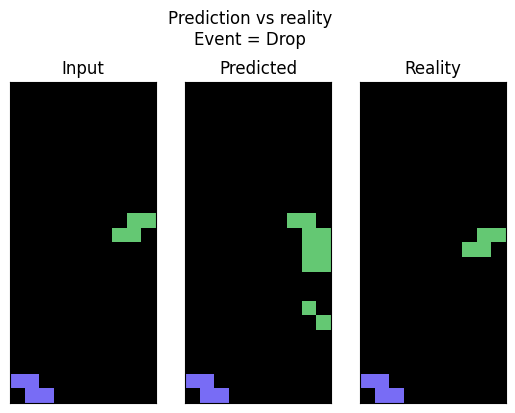

In [160]:
# Show a random training prediction vs reality
import random

idx = random.randrange(len(train_dataset))
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])